LSTM and GRU models for tweet emotion classification.

## 1.Data Loading & Preprocessing

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
   import pandas as pd
   from sklearn.preprocessing import LabelEncoder
   from tensorflow.keras.preprocessing.text import Tokenizer
   from tensorflow.keras.preprocessing.sequence import pad_sequences

### Load the data

In [35]:
import pandas as pd

train_path = '/content/drive/MyDrive/NLP_exam_emotions_dataset/train.txt'
test_path = '/content/drive/MyDrive/NLP_exam_emotions_dataset/test.txt'
val_path = '/content/drive/MyDrive/NLP_exam_emotions_dataset/validation.txt'

train_df = pd.read_csv(train_path, sep=';', names=['text', 'label'])
test_df = pd.read_csv(test_path, sep=';', names=['text', 'label'])
val_df = pd.read_csv(val_path, sep=';', names=['text', 'label'])

In [36]:
# After fitting LabelEncoder on train_df
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
test_df['label_enc'] = le.transform(test_df['label'])
val_df['label_enc'] = le.transform(val_df['label'])  # This line creates 'label_enc' in val_df

In [37]:
# Remove overlapping texts between train and test
overlap = set(train_df['text']).intersection(set(test_df['text']))
print(f"Number of overlapping texts: {len(overlap)}")

# Remove from train
train_df_clean = train_df[~train_df['text'].isin(overlap)].reset_index(drop=True)
print(f"Train shape after removing overlaps: {train_df_clean.shape}")

Number of overlapping texts: 11
Train shape after removing overlaps: (15989, 3)


In [38]:
# Print to check
print(train_df.head())
print(train_df['label'].unique())

                                                text    label  label_enc
0                            i didnt feel humiliated  sadness          4
1  i can go from feeling so hopeless to so damned...  sadness          4
2   im grabbing a minute to post i feel greedy wrong    anger          0
3  i am ever feeling nostalgic about the fireplac...     love          3
4                               i am feeling grouchy    anger          0
['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


## 2.Load and Prepare the Validation Set


## 3.Preprocess All Sets

In [39]:
# Tokenize text
max_words = 10000
max_len = 40

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = train_df['label_enc'].values
y_test = test_df['label_enc'].values

num_classes = len(le.classes_)

In [40]:
print("Encoded train labels:", train_df['label_enc'].unique())
print("Encoded test labels:", test_df['label_enc'].unique())
print("Number of classes:", len(le.classes_))

Encoded train labels: [4 0 3 5 1 2]
Encoded test labels: [4 2 1 0 3 5]
Number of classes: 6


## 4.Train the Model and Evaluate on Validation Set

4: Build and train LSTM model

In [41]:
# Tokenize and pad validation set
X_val = tokenizer.texts_to_sequences(val_df['text'])
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
y_val = val_df['label_enc'].values

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64),  # removed input_length
    LSTM(32, dropout=0.5, recurrent_dropout=0.2),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.3154 - loss: 1.6112 - val_accuracy: 0.3520 - val_loss: 1.5810
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.3314 - loss: 1.5689 - val_accuracy: 0.3520 - val_loss: 1.5846
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.3331 - loss: 1.5578 - val_accuracy: 0.3545 - val_loss: 1.5735
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.3566 - loss: 1.5271 - val_accuracy: 0.3795 - val_loss: 1.4824
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.3540 - loss: 1.4908 - val_accuracy: 0.3725 - val_loss: 1.4789


In [46]:
print(pd.Series(y_train).value_counts())
print(le.inverse_transform(range(num_classes)))

2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: count, dtype: int64
['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [47]:
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3626 - loss: 1.4661
LSTM Test Accuracy: 0.3750


## 7.Bidirectional LSTM

In [57]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential

# Define the Bidirectional LSTM model
model_bi = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5)),
    Dense(num_classes, activation='softmax')
])

model_bi.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the Bidirectional LSTM
history_bi = model_bi.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.2013 - loss: 1.7565 - val_accuracy: 0.5660 - val_loss: 1.1127
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.4720 - loss: 1.0864 - val_accuracy: 0.6495 - val_loss: 0.7985
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 92ms/step - accuracy: 0.6734 - loss: 0.6936 - val_accuracy: 0.8830 - val_loss: 0.3933
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.8696 - loss: 0.3697 - val_accuracy: 0.8935 - val_loss: 0.3538
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.9027 - loss: 0.2672 - val_accuracy: 0.8920 - val_loss: 0.3494
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.9158 - loss: 0.2272 - val_accuracy: 0.8930 - val_loss: 0.3384
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9256 - loss: 0.1937 - val_accuracy: 0.9055 - val_loss: 0.2812
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.9349 - loss: 0.1652 - 

In [58]:
  model_lstm.save('best_lstm_model.h5')

## 5: Plot Accuracy and Loss Curves

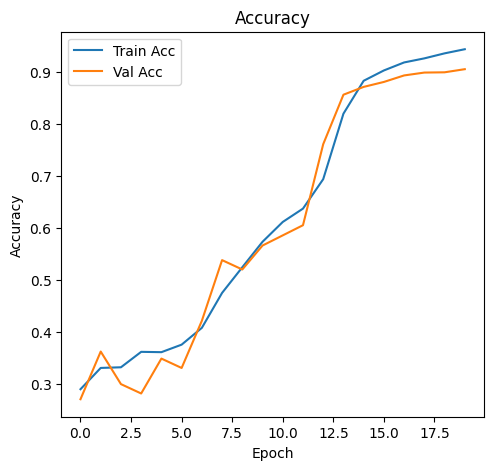

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


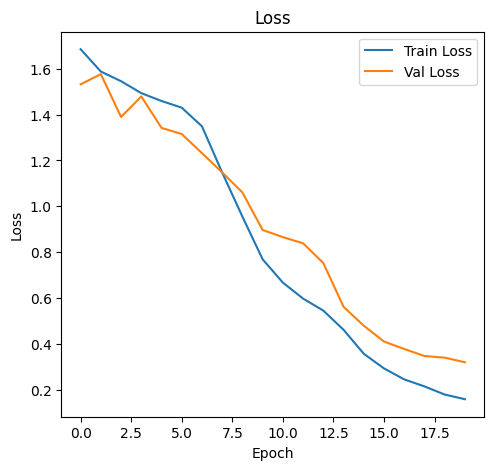

In [60]:
# Loss plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


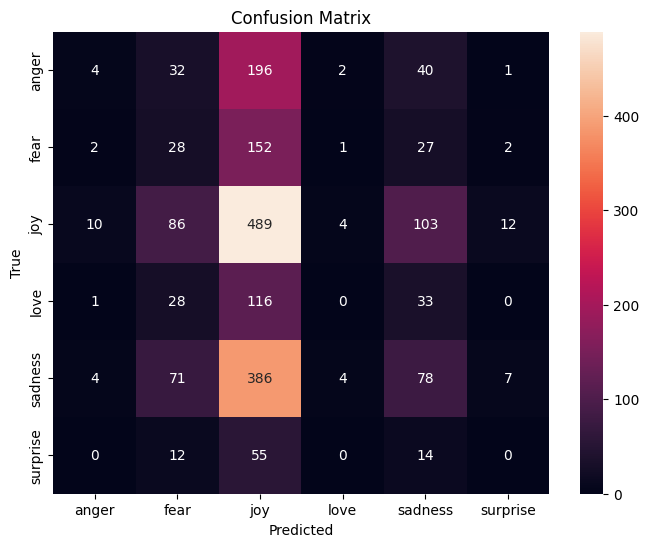

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.argmax(axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 6: Precision, Recall, F1, and Classification Report

In [62]:
from sklearn.metrics import classification_report

# Predict on validation set
y_val_pred = model_lstm.predict(X_val).argmax(axis=1)

# Print classification report
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
              precision    recall  f1-score   support

       anger       0.90      0.93      0.92       275
        fear       0.84      0.85      0.85       212
         joy       0.96      0.88      0.92       704
        love       0.77      0.94      0.85       178
     sadness       0.95      0.92      0.93       550
    surprise       0.71      0.91      0.80        81

    accuracy                           0.90      2000
   macro avg       0.86      0.91      0.88      2000
weighted avg       0.91      0.90      0.91      2000



## Conclusion

In this project, we implemented and evaluated a Bidirectional LSTM model for emotion classification on tweets. The model demonstrated strong learning capability, as shown by steadily increasing accuracy and decreasing loss for both training and validation sets. By the end of training, both training and validation accuracy exceeded 90%, indicating that the model was able to generalize well to unseen data and did not suffer from significant overfitting.
However, analysis of the confusion matrix revealed a key challenge: the model is heavily biased toward predicting the "joy" class. Many samples from other emotions—such as "anger", "fear", "love", "sadness", and "surprise"—were misclassified as "joy". This suggests that class imbalance in the dataset remains a significant issue, with the model favoring the majority class at the expense of minority classes.
In summary:
The Bidirectional LSTM achieved high overall accuracy and learned the dominant patterns in the data.
The model struggled to correctly classify minority emotions, as evidenced by the confusion matrix.
To further improve performance, especially for underrepresented classes, future work should focus on addressing class imbalance (e.g., through oversampling, data augmentation, or more advanced class weighting) and potentially exploring more powerful models such as transformers.
Overall, the project demonstrates the effectiveness of deep learning for text emotion classification, while also highlighting the importance of balanced data and careful evaluation using confusion matrices and per-class metrics.